!pip install connectivipy

!pip install pyEDFlib

!pip install networkx

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import numpy as np
import pyedflib
import pandas as pd
import connectivipy as cp

In [3]:
file_name= 'S038R01.edf'
file_name2= 'S038R02.edf'

In [4]:
def read_data_file(file):
    f = pyedflib.EdfReader(file)
    
    n = f.signals_in_file
    #signal_labels = f.getSignalLabels()
    signal_labels = [name.replace(".","") for name in f.getSignalLabels()]
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    #data=pd.DataFrame(sigbufs).T
    #data.columns=signal_labels
    return signal_labels,sigbufs

In [5]:
labels, data = read_data_file(file_name)
labels2, data2 = read_data_file(file_name2)

1.1 (mandatory) Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

https://connectivipy.readthedocs.io/en/latest/tutorial.html

In [6]:
len(labels)

64

In [7]:
def estimation_1(data, nrepp):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf_values = dt.conn('dtf')
    dtf_significance = dt.significance(Nrep=nrepp, alpha=0.05)
    return dtf_significance

In [8]:
def estimation_2(data, freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    dtf = cp.conn.dtf_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return dtf

In [9]:
def estimation_3(data,freq):
    dt = cp.Data(data, fs=1., chan_names=labels, data_info='sml')
    dt.fit_mvar(method = 'yw')
    ar, vr = dt.mvar_coefficients
    pdc = cp.conn.pdc_fun(ar, vr, fs=10, resolution=100, generalized=False)[freq,:,:]
    return pdc

In [10]:
def find_T_est_1(significance,density): # i think our graph will be directed, 
    #but in case if it is undirected then we need to change formula
    total_num = significance.shape[0]*significance.shape[1]
    k = significance.shape[0]
    n = int(density*total_num+k)
    T = sorted(significance.flatten())[-n]
    return T

In [11]:
def build_adj(est, T):
    adj = 1*(est>T)
    return adj

In [12]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [13]:
def build_graph(adj,labels):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    Edges = [(labels[idx_i[i]],labels[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    our_graph=nx.DiGraph()
    our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


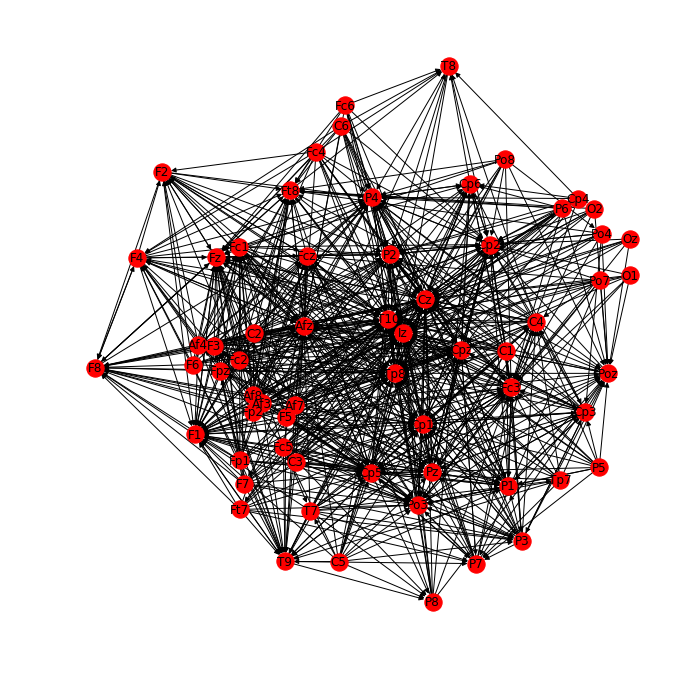

In [14]:
dtf= estimation_2(data,9)
T= find_T_est_1(dtf,0.2)
adjj= build_adj(dtf, T)
gg= build_graph(adjj,labels)

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


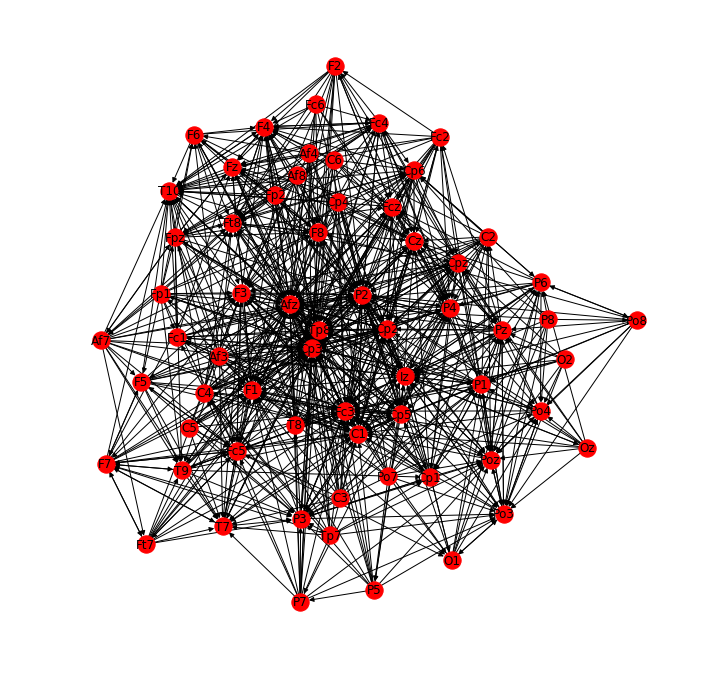

In [15]:
dtf2= estimation_2(data2,9)
T= find_T_est_1(dtf2,0.2)
adjj2= build_adj(dtf2, T)
gg2= build_graph(adjj2,labels2)

In [16]:
np.sum(adjj2)/(63*64) # check density

0.21875

# 1.2
(class ‘A’) Perform task 1.1 using both estimators (PDC and DTF).

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


False


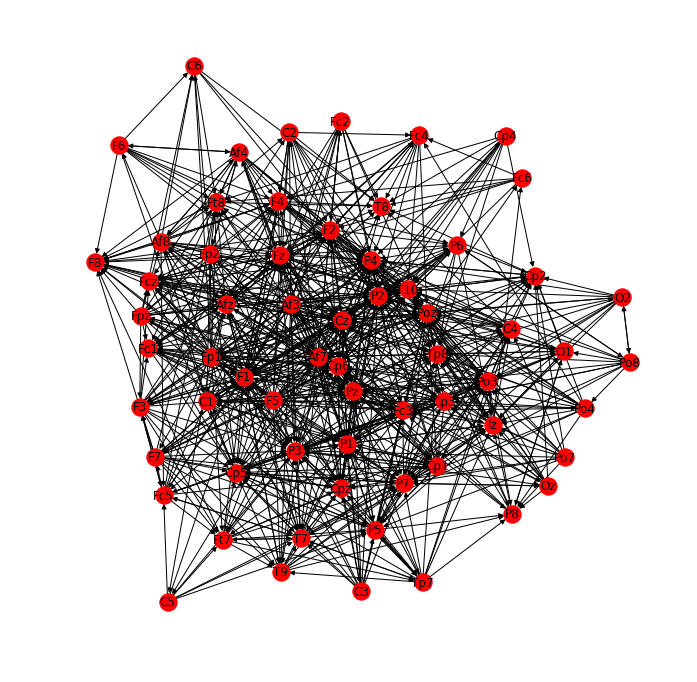

In [17]:
pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.2)
adjj= build_adj(pdc, T)
print(check_symmetric(adjj))
gg3= build_graph(adjj,labels)

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


False


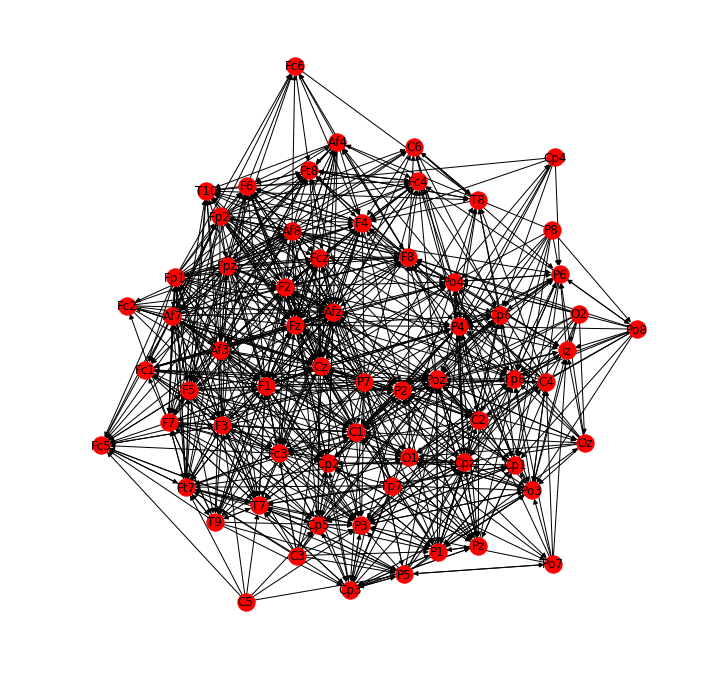

In [18]:
pdc2= estimation_3(data2,9) # second approach

T= find_T_est_1(pdc2,0.2)
adjj3= build_adj(pdc2, T)
print(check_symmetric(adjj3))
gg4= build_graph(adjj3,labels2)

# 1.4.
(class ‘D’) Considering the subset of 19 channels suggested in Figure 1 and Table 2, estimate
the connectivity using PDC or DTF and apply a statistical validation method (asymptotic
statistics 7 , resampling procedure 8 ,...) to filter out values that are not significantly different
from 0 (PDC(i, j) ≠ 0 with p < 5%)

In [19]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels.index(sub_labels[i]) for i in range(19)]
sub_data = data[idx_labels,]

In [20]:
sign_19= estimation_1(sub_data, 100) # in this procedure is already specified alpha=0.05

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


C:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


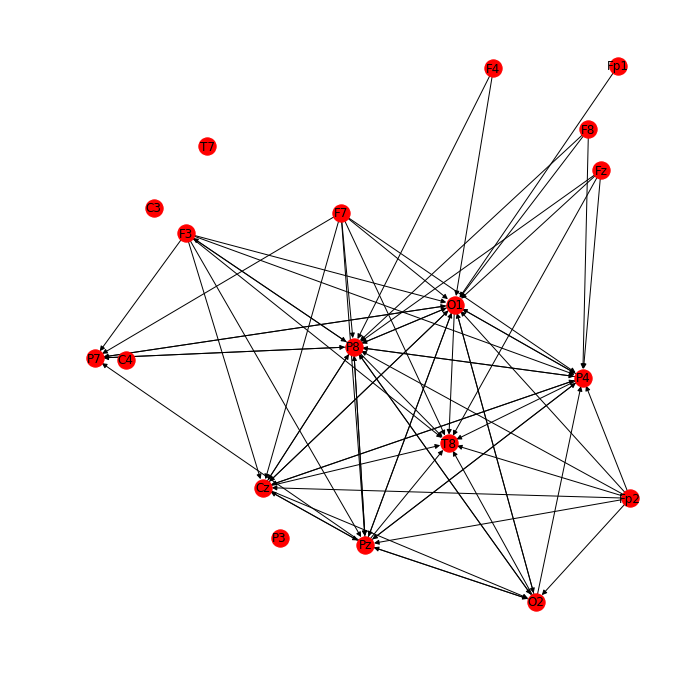

In [21]:
T= find_T_est_1(sign_19,0.2)
adjj19= build_adj(sign_19, T)
gg5= build_graph(adjj19,sub_labels)

In [22]:
sub_labels=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1',\
            'O2']
idx_labels=[labels2.index(sub_labels[i]) for i in range(19)]
sub_data2 = data2[idx_labels,]

In [23]:
sign_19_2= estimation_1(sub_data2, 100) # in this procedure is already specified alpha=0.05

C:\Users\franc\Anaconda3\lib\site-packages\connectivipy\mvar\fitting.py:267: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  req = np.vstack(rr_b[:, :, x].T for x in range(1, pmax+1))


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . |


C:\Users\franc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


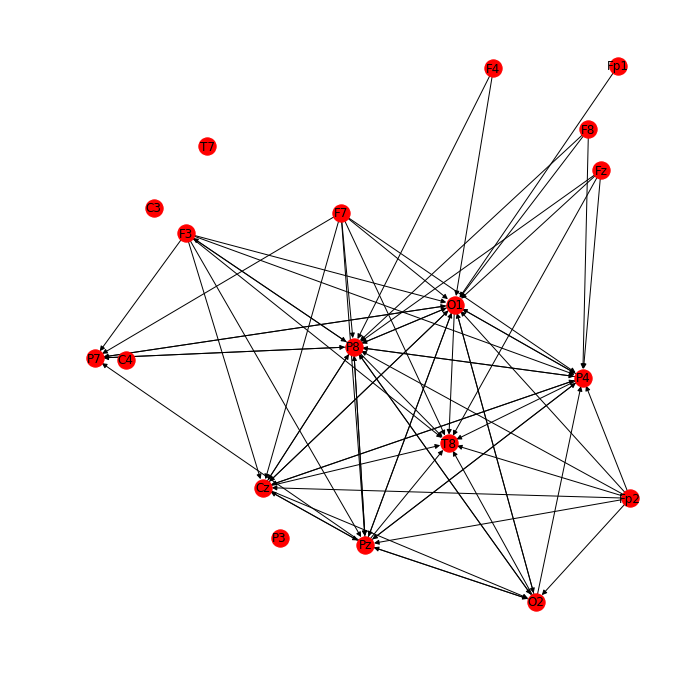

In [24]:
T= find_T_est_1(sign_19,0.2)
adjj19_2= build_adj(sign_19, T)
gg6= build_graph(adjj19_2,sub_labels)

# 1.5.
(class ‘C’) Make a topographical representation of the networks (see example in Figure 2).
Cartesian coordinates of planar representation of EEG channels are available in Table 3 (see
also
the
file
channel_locations.txt).
(the choice of this task is advised in the case of 19-channel networks and/or density ≤ 5%).

In [25]:
#channel_locations.txt
chanel_locations = pd.read_table('channel_locations.txt', sep=' ', usecols=['label','x','y'])
chanel_locations['label']=chanel_locations['label'].str.replace('.','')

In [26]:
chanel_locations[chanel_locations['label']=='Fc5']['x'].values.item(0)

-0.278155156

In [27]:
def build_graph(adj,nodes,labels,coord):
    idx_i, inx_j = np.where(adj==1)
    idx_i, inx_j = list(idx_i), list(inx_j )
    #check_symmetric(adj_matr)
    our_graph=nx.DiGraph()
    for i in range(len(labels)):
        our_graph.add_node(labels[i],
                          pos=(coord[coord['label']==labels[i]]['x'].values.item(0),
                              coord[coord['label']==labels[i]]['y'].values.item(0)))
    Edges = [(nodes[idx_i[i]],nodes[inx_j[i]]) for i in range(len(idx_i)) if (idx_i[i]!=inx_j[i])]
    
    #our_graph.add_nodes_from(labels)
    our_graph.add_edges_from(Edges)
    pos=nx.get_node_attributes(our_graph,'pos')
    #pos = nx.kamada_kawai_layout(our_graph)
    plt.figure(3,figsize=(9,9)) 
    nx.draw(our_graph,pos,with_labels=True)
    #plt.figure(3,figsize=(16,16)) 
    plt.draw()
    plt.show()
    return our_graph

False


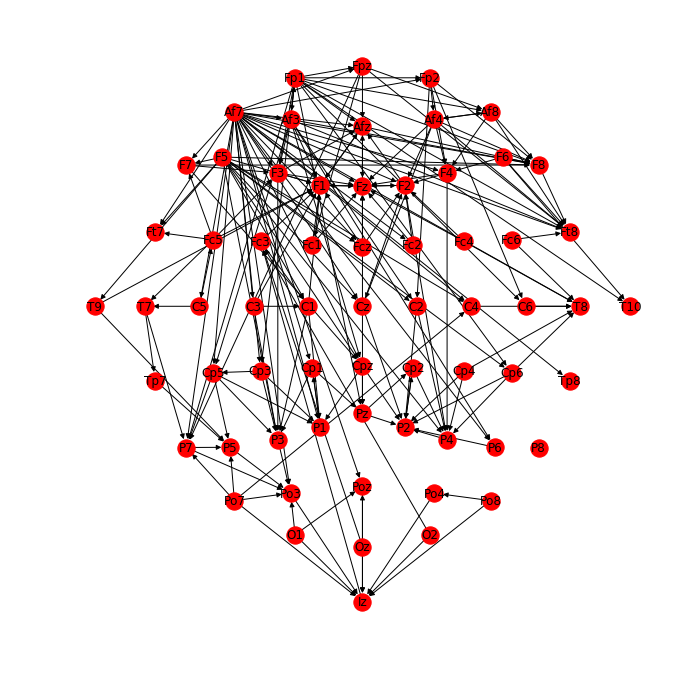

In [28]:
#pdc= estimation_3(data,9) # second approach

T= find_T_est_1(pdc,0.05)
adjj005= build_adj(pdc, T)
print(check_symmetric(adjj005))
gg7= build_graph(adjj005,labels,labels,chanel_locations)

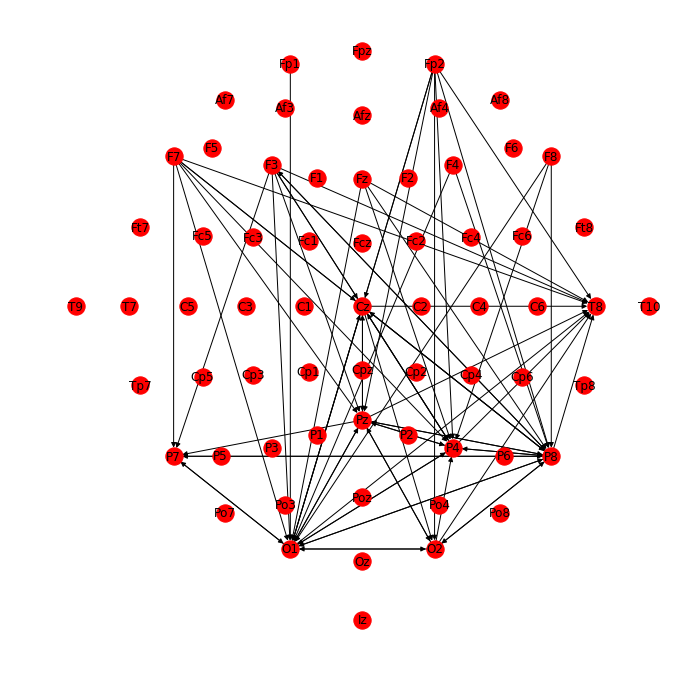

In [29]:
gg7= build_graph(adjj19,sub_labels,labels,chanel_locations)

# 2.1
(mandatory) Compute binary global (clustering coefficient, path length) and local (degree,
in/out-degree) graph indices. List the highest 10 channels for local indices.


C_n = e_n/(k_n(k_n-1))
C_n - clustering coeff of node n
e_n - number of edges among neigbors
k_n - number possible edges number

In [30]:
#global clustering coefficient, is avg of CC among all nodes
def avg_CC(graph):
    CC=[]
    for node in graph.nodes:
        #print(node)
        neighbors = (set(gg.successors(node))).union(set(gg.predecessors(node)))
        #print(neighbors)
        e=0
        for ne in neighbors:
            edges = set(graph.in_edges(ne))
            edges = edges.union(set(graph.out_edges(ne)))
            #print("edges")
            #print(edges)
            for edg in edges:
                x, y = edg
                if (x in neighbors) and (y in neighbors):
                    e=e+1
                    #print(1)
        #print(e)
        k = len(neighbors)*(len(neighbors)-1)
        #print(k)
        CC.append(e/k)
    return np.mean(CC)

In [31]:
avg_CC(gg) # so it is closer to 1, we can say that network can form some clusters

0.8041932158659955

The **global/average path length** is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. We can calculate the average path length of a graph by using this following formula:

*l*<sub>G</sub> = $\frac{1}{n(n-1)}\sum_{i \neq j}d(v_{i}, v_{j})$

where $d(v_{i}, v_{j})$ represents the length of shortest path exists between two vertices and *_n_* the number of vertices in *G*. <br> So, we take sum of all shortest paths between all vertices and divide number of all possible paths.

In [32]:
#global/average path length
def avg_path(graph):
    l=[]
    for node in graph:
        # find all the descendants for each node
        descendants = set(nx.shortest_path_length(graph, node)) - set([node])
        e=0
        for x in descendants:
            # shortest path between two vertices
            s_p = nx.shortest_path_length(graph,source=node,target=x)
            e=e+s_p
        l.append(e)
        e_t = sum(l)
        k = len(graph.nodes())*(len(graph.nodes())-1)
    return (e_t/k)

In [33]:
#the average path length is:
avg_path(gg)

0.8432539682539683

In [34]:
#SHORTEST VERSION
def average_path(graph):
    return(nx.average_shortest_path_length(graph))

In [35]:
print(average_path(gg))

0.8432539682539683


The **degree** of a node *_i_* (*_i_* $\in [1, N], N$ number of nodes) is the total number of connections with other vertices. 
<br> The greater the degree, the more important is the presence of that node for the whole system.

In directed graph, the degree can be split into **in-degree** and **out-degree**: <br>

*In-degree* of node *_i_* is the total amount of links incoming to the vertex *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{in} = \sum_{j = 1, i \neq j}^{N} a_{ji}$, &nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{in}\in [0, N-1]$

*Out-degree* of node *_i_* is the total amount of links outgoing from the vertex *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{out} = \sum_{j = 1, i \neq j}^{N} a_{ij}$, &nbsp;&nbsp;&nbsp;&nbsp; $k_{i}^{out}\in [0, N-1]$

*Degree* of node *_i_* is the sum of incoming and outgoing degrees of node *_i_*:
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k_{i} = k_{i}^{in} + k_{i}^{out}$

In [36]:
#in-degree
def in_degree(graph):
    in_d_10 = sorted(graph.in_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(in_d_10)

In [37]:
#highest 10 channels for in-degree 
in_degree(gg) 

[('T10', 60),
 ('Iz', 60),
 ('Tp8', 56),
 ('Cz', 47),
 ('P2', 38),
 ('Cp2', 33),
 ('Cp1', 32),
 ('Fz', 30),
 ('Fc3', 29),
 ('Afz', 29)]

In [38]:
#out-degree
def out_degree(graph):
    out_d_10 = sorted(graph.out_degree(), key = lambda x: x[1], reverse = True)[:10]
    return(out_d_10)

In [39]:
#highest 10 channels for out-degree
out_degree(gg)

[('Cp5', 21),
 ('Afz', 20),
 ('Cp3', 19),
 ('Af7', 19),
 ('Fc5', 18),
 ('Fc3', 18),
 ('Fp1', 18),
 ('Fp2', 18),
 ('Af3', 18),
 ('F5', 18)]

In [40]:
#degree
def degree(graph):
    d_10 = sorted(graph.degree(), key = lambda x: x[1], reverse = True)[:10]
    return(d_10)

In [41]:
#highest 10 channels for degree
degree(gg)

[('Iz', 68),
 ('Cz', 61),
 ('Tp8', 61),
 ('T10', 60),
 ('Cp5', 49),
 ('Cp1', 49),
 ('Afz', 49),
 ('Fc3', 47),
 ('P2', 46),
 ('Cp2', 44)]

# 2.3

(class 'B') Compare the global indices extracted from PDC and DTF connectivity estimations.

In [42]:
#global clustering coefficient with PDC
avg_CC(gg3)

0.5736658793167271

In [43]:
#average path length with PDC
avg_path(gg3)

2.6731150793650795